In [27]:
import matplotlib.pyplot as plt
import numpy as np
import os, scipy

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')
    os.chdir('..')
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.optimal_control import oc_wc, cost_functions
from neurolib.optimal_control.oc_utils.plot_oc import plot_oc_network

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
comp_points = [[1., 0.5], [2.8, 1.6], [3., 0.5], [2., 0.5]]

target oscillation period =  15.68


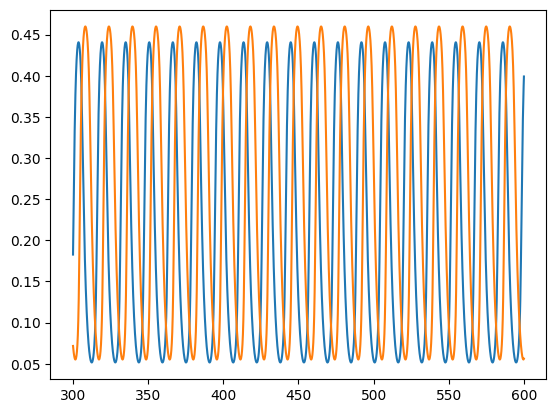

In [43]:
cmat = np.zeros((2,2))
#cmat[0,1] = 1.
cmat[1,0] = 1.
dmat = 20. * cmat.copy()

controlmat = np.zeros((2,2))
controlmat[0,0] = 1.

model = WCModel(Cmat=cmat, Dmat=dmat)

dt = 0.1
model.params['dt'] = dt # Integration time step, ms
model.params['duration'] = 1. * 1000 # Simulation time, ms
model.params["exc_ext"] = 2.
model.params["inh_ext"] = 0.5

model.run()

peaks = scipy.signal.find_peaks(model.exc[0,100:])[0]
plist = []
for pind in range(1, len(peaks)):
    plist.append(model.params.dt * (peaks[pind]-peaks[pind-1]))

period = np.around(np.mean(plist),2)
print("target oscillation period = ", period)

plt.plot(model.t[3000:6000], model.exc[0,3000:6000])
plt.plot(model.t[3000:6000], model.exc[1,3000:6000])
plt.show()

In [44]:
duration = 300.
model.params.duration = duration
zero_input0 = ZeroInput().generate_input(duration=duration+model.params.dt, dt=model.params.dt)
zero_input = np.vstack( (zero_input0, zero_input0))
zero_control0 = np.concatenate( (zero_input,zero_input), axis=0)[np.newaxis,:,:]
zero_control = np.vstack( (zero_control0, zero_control0))
print(zero_input.shape, zero_control.shape)

(2, 3001) (2, 4, 3001)


In [45]:
results = dict()
w2_array = [1e-3, 1e-5]
proms = [0.01, 0.03, 0.1, 0.3]
results["controls"] =  [ [ None, None, None, None ], [ None, None, None, None ], [ None, None, None, None ], [ None, None, None, None ] ]
target_period = 0.7*period
int0 = int(2000 - (16. * target_period / model.params.dt))

# Fourier cost at four different points, with different weights

--------------------------------
--------------------------------
--------------------------------
POINT :  [1.0, 0.5]
Target period =  10.975999999999999
Delay not yet implemented, please set delays to zero
Optimal control with target oscillation period
L2 cost weight =  0.001
Compute control for a deterministic system
Cost in iteration 0: -0.6163514484920172
Converged in iteration 2 with cost -0.6163514484920172
Final cost : -0.6163514484920172


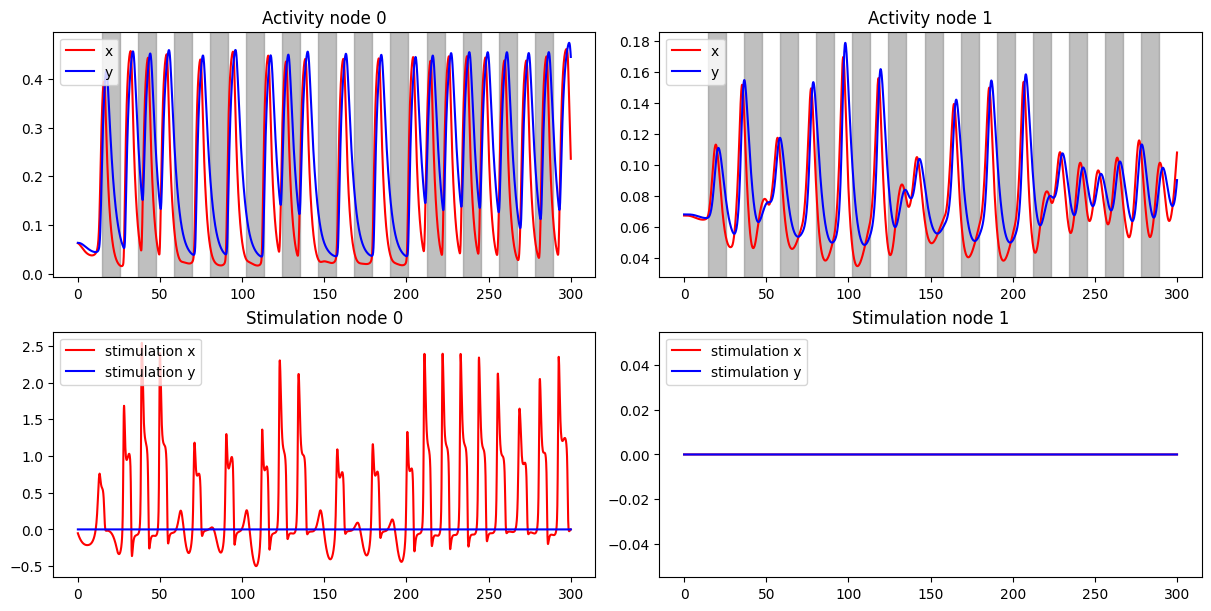

Delay not yet implemented, please set delays to zero
Optimal control with target oscillation period
L2 cost weight =  1e-05
Compute control for a deterministic system
Cost in iteration 0: -0.8656453392303505
Converged in iteration 2 with cost -0.8656453392303505
Final cost : -0.8656453392303505


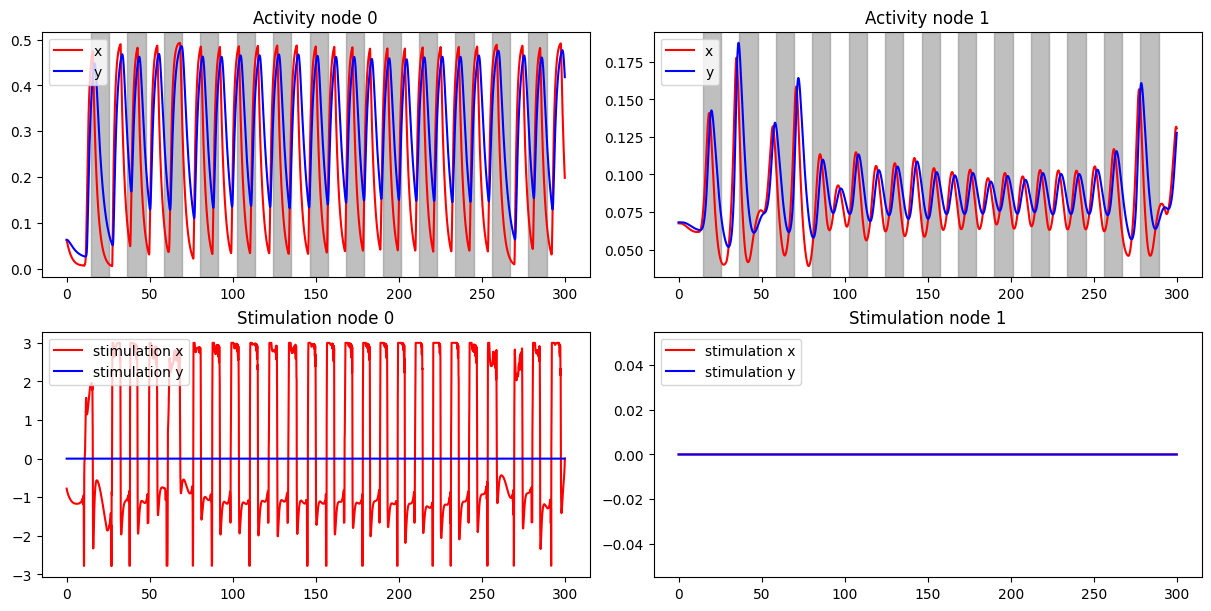

--------------------------------
--------------------------------
--------------------------------
POINT :  [2.8, 1.6]
Target period =  10.975999999999999
--------------------------------
--------------------------------
--------------------------------
POINT :  [3.0, 0.5]
Target period =  10.975999999999999
--------------------------------
--------------------------------
--------------------------------
POINT :  [2.0, 0.5]
Target period =  10.975999999999999


In [48]:
it = 100
pr = np.arange(0,101,10)
maxstr = 3.

for pind in range(len(comp_points)):
    p = comp_points[pind]
    print("--------------------------------")
    print("--------------------------------")
    print("--------------------------------")
    print("POINT : ", p)
    print("Target period = ", target_period)

    if pind not in [0]:
        continue

    model.params["exc_ext"] = zero_input + p[0]
    model.params["inh_ext"] = zero_input + p[1]
    model.run()

    model.params["exc_init"] = np.vstack( [model.exc[0,-1], model.exc[1,-1]] )
    model.params["inh_init"] = np.vstack( [model.inh[0,-1], model.inh[1,-1]] )

    for iw in range(len(w2_array)):
        w2 = w2_array[iw]

        if iw not in [0,1]:
            continue


        model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int0,None), control_matrix = controlmat, )
        model_controlled.maximum_control_strength = maxstr
        model_controlled.weights["w_p"] = 0.
        model_controlled.weights["w_f"] = 1.
        model_controlled.weights["w_2"] = w2
        print("L2 cost weight = ", w2)

        if type(results["controls"][pind][iw]) != type(None):
            model_controlled.control = results["controls"][pind][iw]
            model_controlled.update_input()

        model_controlled.optimize(it)
        results["controls"][pind][iw] = model_controlled.control.copy()

        plot_oc_network(2, duration, dt, model_controlled.get_xs(), target_period,  model_controlled.control)